<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예
- from https://www.cis.fordham.edu/wisdm/dataset.php
- sampled at every 50 msec

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from tensorflow.keras import utils

## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking


In [ ]:
# 소수점 세 자리만 표시
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=3)

LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

- download data from https://www.cis.fordham.edu/wisdm/dataset.php and save it in the current directory
- 11.138 Mbytes

In [ ]:
!ls -l

total 13064
drwxr-xr-x 1 root root     4096 Aug  9 13:37 sample_data
-rw-r--r-- 1 root root 13372040 Aug 11 05:28 WISDM_ar_latest.tar.gz


In [ ]:
!gunzip WISDM_ar_latest.tar.gz


gzip: WISDM_ar_latest.tar.gz: invalid compressed data--format violated


In [ ]:
!tar -xf ./WISDM_ar_latest.tar

tar: ./WISDM_ar_latest.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!ls -l WISDM_ar_v1.1

ls: cannot access 'WISDM_ar_v1.1': No such file or directory


In [ ]:
# !head -5 ./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

head: cannot open './WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt' for reading: No such file or directory


In [ ]:
!head -5 ./WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [ ]:
def read_data(file_path):
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names,
                     on_bad_lines='skip')
    # 마지막 컬럼에서 ";"를 삭제

    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # 결측치 처리
    df.dropna(axis=0, how='any', inplace=True)   # drop rows if 'any' missing value

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan


# df = read_data('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
df = read_data('./WISDM_ar_v1.1_raw.txt')

<ipython-input-15-f05eb31fc9e3>:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


In [ ]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.695,12.681,0.504
1,33,Jogging,49106062271000,5.012,11.264,0.953
2,33,Jogging,49106112167000,4.903,10.883,-0.082
3,33,Jogging,49106222305000,-0.613,18.496,3.024
4,33,Jogging,49106332290000,-1.185,12.108,7.205


In [ ]:
df.shape

(1086465, 6)

In [ ]:
df['activity'].value_counts()

Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: activity, dtype: int64

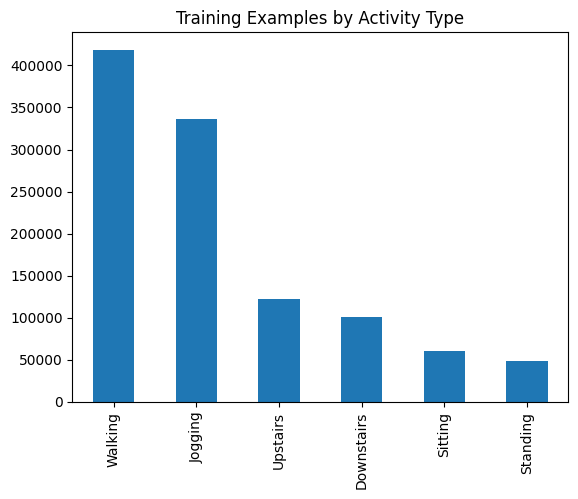

In [ ]:
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()

In [ ]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1073623, 6)

- 사용자별로 샘플이 몇 개인지 분포를 보자

[]

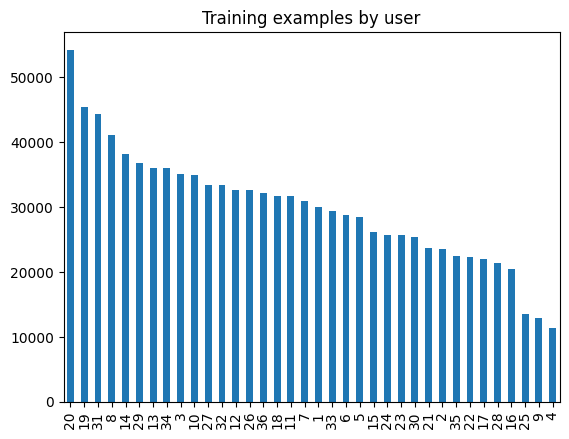

In [ ]:
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training examples by user')
plt.plot()

- 이제 6가지 각 행동 패턴에 대해 일부 시간의 시계열 데이터를 확인한다. 300 개의 샘플이고, 이는 300 * 50 ms = 15 초에 해당하는 시간의 그래프다.

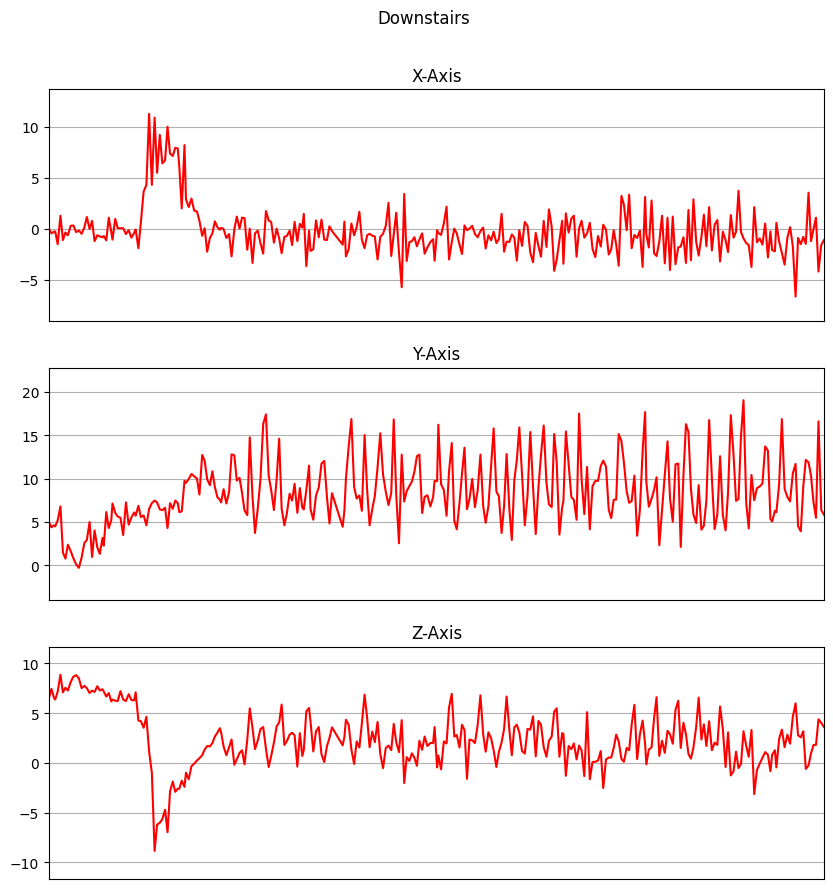

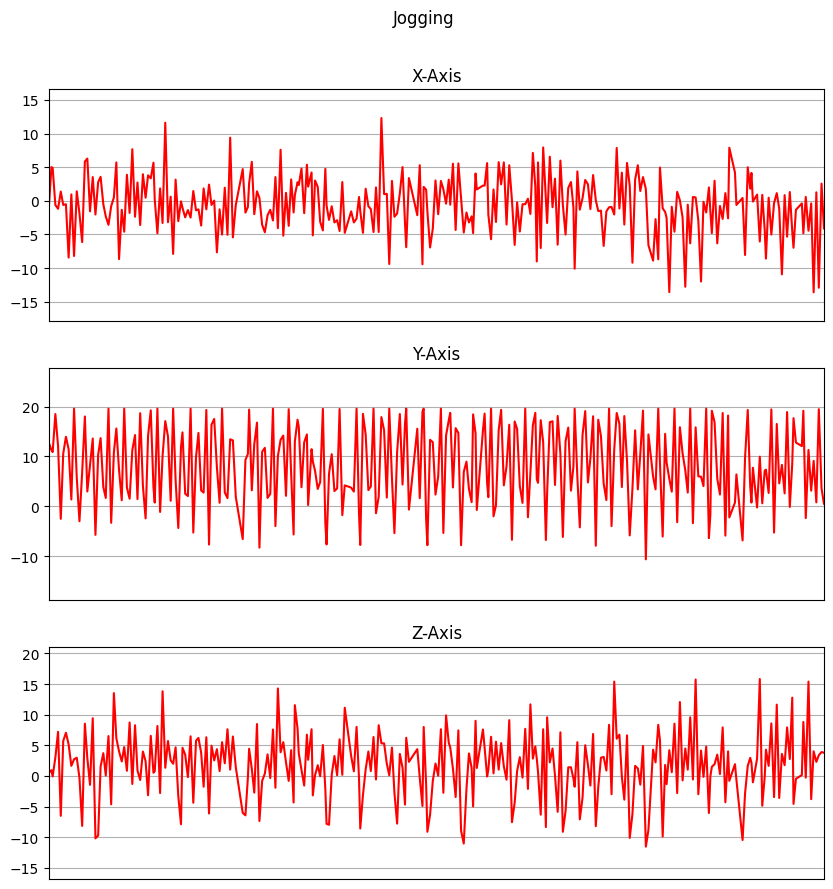

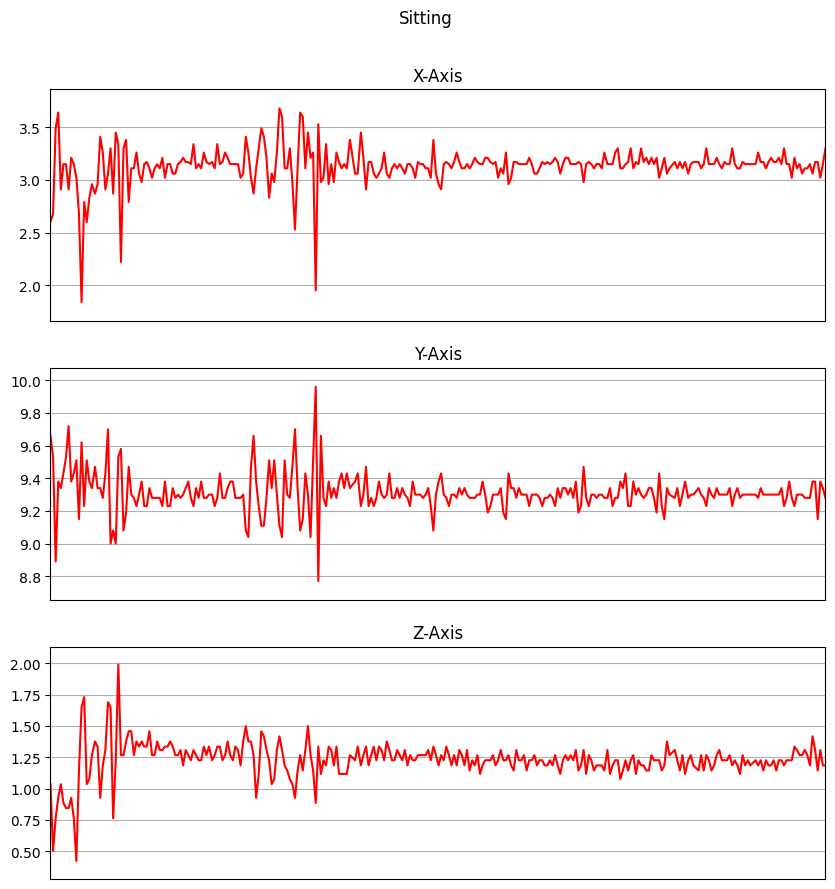

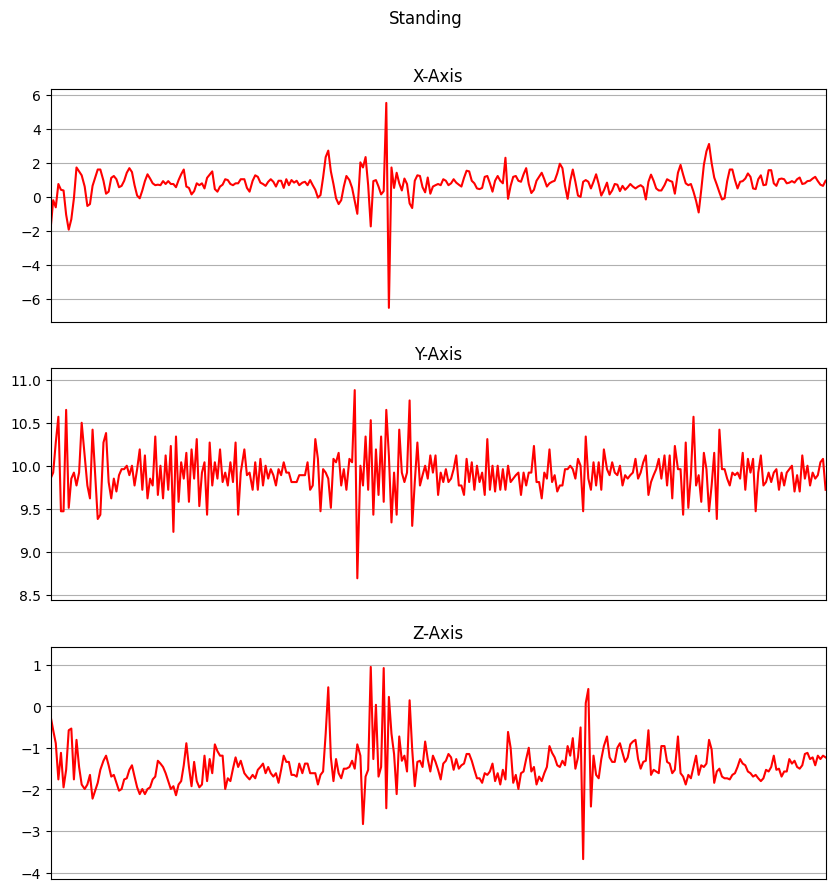

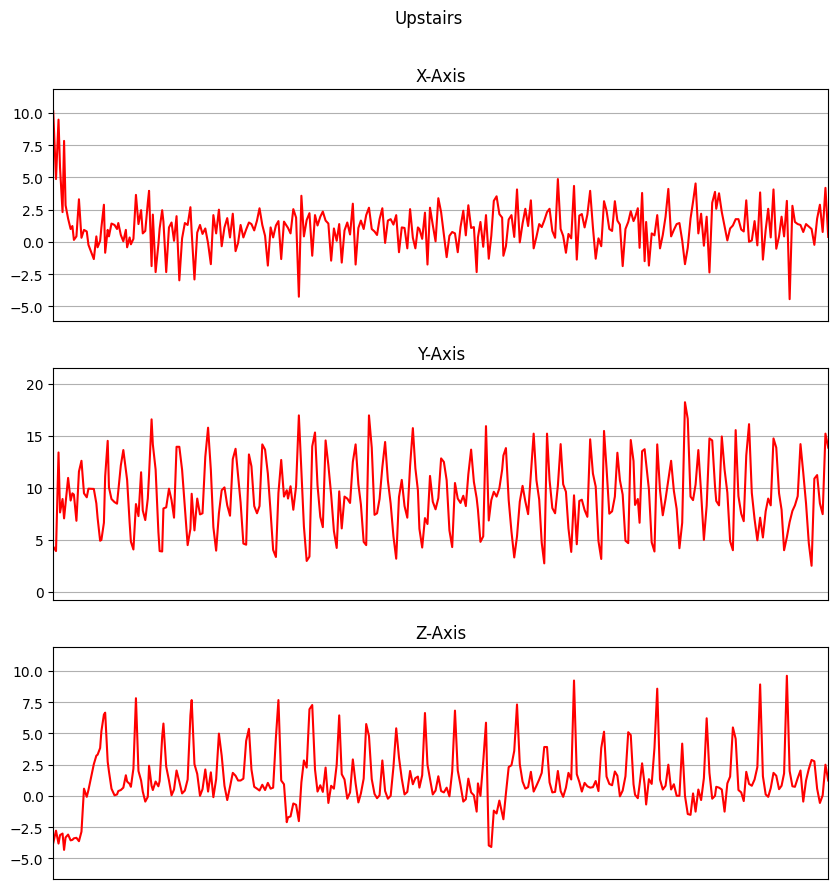

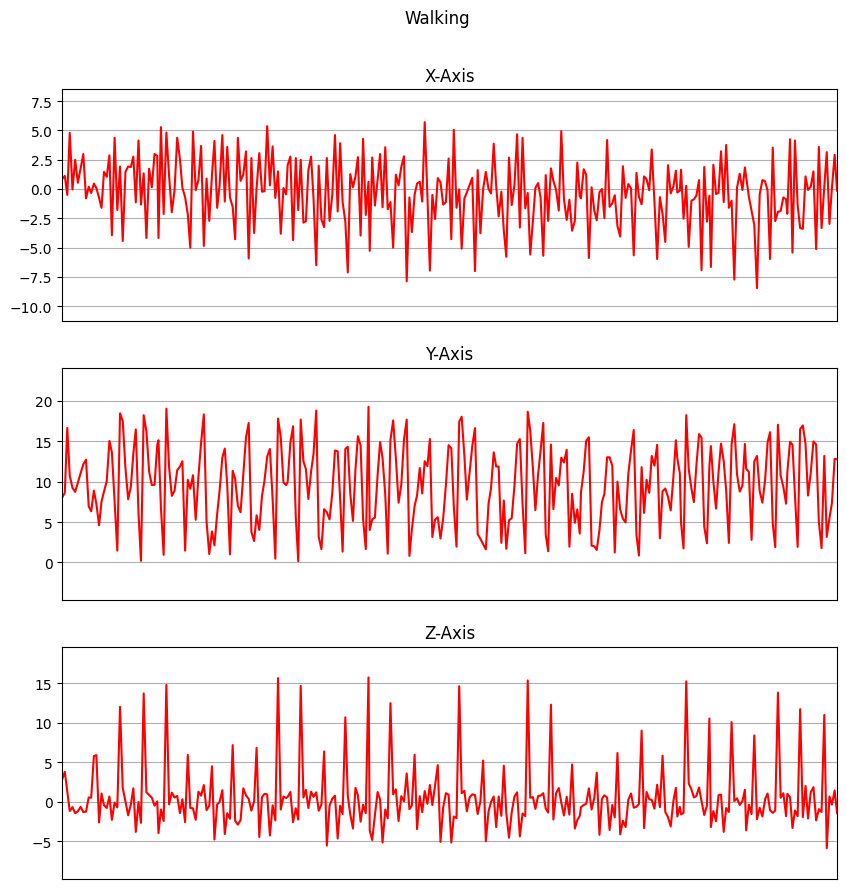

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

위 그래프를 보면 6 가지 동작에 대해 모양이 다른 것은 구분이 되지만 이를 프로그램이 찾게 하는 것이 목적이다.

In [ ]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [ ]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.695,12.681,0.504,1
1,33,Jogging,49106062271000,5.012,11.264,0.953,1
2,33,Jogging,49106112167000,4.903,10.883,-0.082,1
3,33,Jogging,49106222305000,-0.613,18.496,3.024,1
4,33,Jogging,49106332290000,-1.185,12.108,7.205,1


In [ ]:
df['activity'].value_counts()   # 각 행동에 대한 분포

Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: activity, dtype: int64

In [ ]:
df['act'].value_counts()

5    417901
1    324600
4    122598
0    100192
2     59939
3     48393
Name: act, dtype: int64

In [ ]:
# just for checking
test = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
stats.mode(test), stats.mode(test)[0], stats.mode(test)[1]

<ipython-input-27-72df730523bd>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(test), stats.mode(test)[0], stats.mode(test)[1]


(ModeResult(mode=array([3]), count=array([15])), array([3]), array([15]))

- 동작을 5초 단위 (샘플은 100 개)로 구분하고 구간 5초 내에 어떤 동작이 가장 많이 들어 있는지 찾는다.  

In [ ]:
z = stats.mode(df['act'][0:100])
z[0], z[1], z[0][0], z[1][0]

<ipython-input-28-1a17dec8559e>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][0:100])


(array([1]), array([100]), 1, 100)

In [ ]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [ ]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [ ]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198,0.794,0.021,1
1,33,Jogging,49106062271000,0.627,0.584,0.115,1
2,33,Jogging,49106112167000,0.612,0.527,-0.101,1
3,33,Jogging,49106222305000,-0.186,1.658,0.547,1
4,33,Jogging,49106332290000,-0.268,0.709,1.420,1


In [ ]:
df['x-axis'].values[: 100]

array([-0.198,  0.627,  0.612, -0.186, -0.268,  0.102, -0.186, -0.17 ,
       -1.316,  0.041, -1.283,  0.108, -0.369, -0.983,  0.746,  0.811,
       -0.324,  0.413, -0.391,  0.303,  0.419, -0.17 , -0.43 , -0.613,
       -0.213, -0.024,  0.728, -1.35 , -0.29 , -0.761,  0.462, -0.357,
        1.011, -0.44 ,  0.297, -0.617,  0.474, -0.03 ,  0.45 ,  0.385,
        0.722, -0.064, -0.794,  0.169, -0.574,  1.581, -0.556, -0.009,
       -1.237,  0.358, -0.534, -0.109, -0.247, -0.452, -0.296, -0.458,
        0.114, -0.302, -0.28 , -0.629,  0.169, -0.28 ,  0.251, -0.186,
       -0.091, -1.204, -0.28 , -0.822,  0.184, -0.828,  1.26 , -0.883,
       -0.186,  0.584, -0.351, -0.229,  0.279,  0.74 , -0.385,  0.108,
       -0.036, -0.613, -0.773, -0.406, -0.29 , -0.519,  0.413, -0.684,
        1.   , -0.845,  0.074, -0.635,  0.362, -0.347,  0.025,  0.303,
        0.242,  0.596, -0.363,  0.679])

In [ ]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다
N = 100
X_all = []
y = []
for i in range(0, len(df)-N+1, N):
    z = stats.mode(df['act'][i: i+N])
    action, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X_all.append([xs, ys, zs])
        y.append(action)


<ipython-input-35-8ec152b1b048>:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][i: i+N])


In [ ]:
np.shape(X_all), np.shape(y)

((10355, 3, 100), (10355,))

In [ ]:
# Bring the segments into a better shape

X_all = np.asarray(X_all, dtype= np.float32)
y = np.asarray(y)

In [ ]:
X_all.shape, y.shape

((10355, 3, 100), (10355,))

In [ ]:
X_3 = np.transpose(X_all, (0,2,1))

In [ ]:
X_3.shape

(10355, 100, 3)

In [ ]:
# z-axis 성분만 추출
X = X_3[:,:,2]
X[0]

array([ 0.021,  0.115, -0.101,  0.547,  1.42 , -1.443,  1.108,  1.389,
        0.988,  0.26 ,  0.485,  0.539, -0.147, -1.788,  1.699,  0.525,
       -0.388,  1.884, -2.211, -2.115,  0.237,  0.692, -0.067,  1.275,
       -1.051,  2.74 ,  1.204,  0.755,  0.411,  0.9  ,  0.092,  1.739,
       -0.357,  1.645,  0.101, -0.221,  0.749,  0.419, -0.741,  1.284,
        0.027,  0.075,  1.619, -0.667,  2.803,  0.195,  1.108,  0.451,
        0.331,  0.891, -0.781, -1.731,  0.877,  0.644, -0.124,  1.267,
       -0.997,  1.116,  1.213,  0.707, -0.451,  1.236, -1.364,  0.948,
        0.445,  0.829,  0.084,  1.068,  0.348,  1.509,  0.132,  1.261,
        0.212, -1.341, -1.426, -0.141,  0.843,  0.155, -0.653,  1.685,
       -1.62 , -0.252, -0.004,  0.653, -0.155,  1.5  , -0.485,  2.899,
        0.724,  1.068,  0.38 , -0.252,  0.795, -0.988,  2.33 ,  1.531,
        0.684,  0.124, -0.411,  1.324], dtype=float32)

In [ ]:
X.shape, y.shape

((10355, 100), (10355,))

In [ ]:
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [ ]:
classes = len(df['act'].unique()); classes

6

In [ ]:
y_hot = utils.to_categorical(y)  # one-hot encoding
y_hot.shape

(10355, 6)

In [ ]:
y_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=42)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
print(rfc.score(X_test,y_test))
print(rfc.predict(X_test[:10]))

0.7952679864799613
[5 5 0 4 1 3 5 5 5 5]


In [ ]:
X_train.shape, y_train.shape

((8284, 100), (8284,))

- RandomforestClassifier supports an one-hot encoded target (not very common, though)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2,
                                                    random_state=42)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.631578947368421

In [ ]:
rfc.predict(X_test[:10])

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train.shape, y_train.shape

((8284, 100), (8284, 6))

- let's try an DNN model

In [ ]:
model_m = Sequential()
model_m.add(Dense(100, activation='relu', input_shape=(100,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배치 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 10
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
655/663 [============================>.] - ETA: 0s - loss: 0.9240 - accuracy: 0.6403

663/663 [==============================] - 8s 4ms/step - loss: 0.9211 - accuracy: 0.6421 - val_loss: 0.6700 - val_accuracy: 0.7749
Epoch 2/30
653/663 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.8003

663/663 [==============================] - 3s 5ms/step - loss: 0.5460 - accuracy: 0.8013 - val_loss: 0.5812 - val_accuracy: 0.7924
Epoch 3/30
657/663 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8449

663/663 [==============================] - 3s 4ms/step - loss: 0.4214 - accuracy: 0.8443 - val_loss: 0.5719 - val_accuracy: 0.8063
Epoch 4/30
661/663 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8696

663/663 [==============================] - 3s 4ms/step - loss: 0.3411 - accuracy: 0.8692 - val_loss: 0.6146 - val_accuracy: 0.8033
Epoch 5/30
659/663 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8985

663/663 [==============================] - 2s 4ms/step - loss: 0.2804 - accuracy: 0.8977 - val_loss: 0.6003 - val_accuracy: 0.8057
Epoch 6/30
657/663 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9145

663/663 [==============================] - 4s 6ms/step - loss: 0.2346 - accuracy: 0.9144 - val_loss: 0.6526 - val_accuracy: 0.8008
Epoch 7/30
662/663 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9317

663/663 [==============================] - 2s 4ms/step - loss: 0.1903 - accuracy: 0.9318 - val_loss: 0.6683 - val_accuracy: 0.8069
Epoch 8/30
649/663 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9430

663/663 [==============================] - 2s 3ms/step - loss: 0.1644 - accuracy: 0.9428 - val_loss: 0.7109 - val_accuracy: 0.8105
Epoch 9/30
653/663 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9547

663/663 [==============================] - 2s 4ms/step - loss: 0.1302 - accuracy: 0.9546 - val_loss: 0.7568 - val_accuracy: 0.8069
Epoch 10/30
653/663 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9636

663/663 [==============================] - 2s 3ms/step - loss: 0.1147 - accuracy: 0.9633 - val_loss: 0.8154 - val_accuracy: 0.7954
Epoch 11/30
658/663 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9669

663/663 [==============================] - 3s 5ms/step - loss: 0.0990 - accuracy: 0.9671 - val_loss: 0.8646 - val_accuracy: 0.7942
Epoch 12/30
646/663 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9771

663/663 [==============================] - 2s 4ms/step - loss: 0.0740 - accuracy: 0.9769 - val_loss: 0.9197 - val_accuracy: 0.8063
Epoch 13/30
660/663 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9750

663/663 [==============================] - 2s 4ms/step - loss: 0.0826 - accuracy: 0.9750 - val_loss: 0.9942 - val_accuracy: 0.7930
Epoch 14/30
660/663 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9755

663/663 [==============================] - 2s 4ms/step - loss: 0.0765 - accuracy: 0.9756 - val_loss: 1.0077 - val_accuracy: 0.7954
Epoch 15/30
651/663 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9813

663/663 [==============================] - 3s 4ms/step - loss: 0.0597 - accuracy: 0.9811 - val_loss: 1.0866 - val_accuracy: 0.7779
Epoch 16/30
650/663 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9878

663/663 [==============================] - 3s 5ms/step - loss: 0.0403 - accuracy: 0.9878 - val_loss: 1.1047 - val_accuracy: 0.7948
Epoch 17/30
663/663 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9888

663/663 [==============================] - 2s 4ms/step - loss: 0.0392 - accuracy: 0.9888 - val_loss: 1.2750 - val_accuracy: 0.8014
Epoch 18/30
663/663 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9760

663/663 [==============================] - 2s 4ms/step - loss: 0.0751 - accuracy: 0.9760 - val_loss: 1.2181 - val_accuracy: 0.7936
Epoch 19/30
653/663 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9832

663/663 [==============================] - 2s 4ms/step - loss: 0.0517 - accuracy: 0.9833 - val_loss: 1.1057 - val_accuracy: 0.8147
Epoch 20/30
654/663 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9878

663/663 [==============================] - 2s 4ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 1.2097 - val_accuracy: 0.7972
Epoch 21/30
656/663 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9848

663/663 [==============================] - 3s 5ms/step - loss: 0.0447 - accuracy: 0.9849 - val_loss: 1.3319 - val_accuracy: 0.7936
Epoch 22/30
655/663 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.9835

663/663 [==============================] - 2s 4ms/step - loss: 0.0453 - accuracy: 0.9831 - val_loss: 1.3381 - val_accuracy: 0.7948
Epoch 23/30
647/663 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9855

663/663 [==============================] - 2s 4ms/step - loss: 0.0419 - accuracy: 0.9855 - val_loss: 1.4086 - val_accuracy: 0.7870
Epoch 24/30
656/663 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9884

663/663 [==============================] - 2s 4ms/step - loss: 0.0340 - accuracy: 0.9882 - val_loss: 1.3654 - val_accuracy: 0.7960
Epoch 25/30
663/663 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9905

663/663 [==============================] - 3s 4ms/step - loss: 0.0268 - accuracy: 0.9905 - val_loss: 1.4597 - val_accuracy: 0.7948
Epoch 26/30
648/663 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9809

663/663 [==============================] - 3s 4ms/step - loss: 0.0563 - accuracy: 0.9810 - val_loss: 1.3491 - val_accuracy: 0.7984
Epoch 27/30
651/663 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9931

663/663 [==============================] - 3s 4ms/step - loss: 0.0233 - accuracy: 0.9929 - val_loss: 1.3955 - val_accuracy: 0.8105
Epoch 28/30
651/663 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9853

663/663 [==============================] - 2s 4ms/step - loss: 0.0436 - accuracy: 0.9854 - val_loss: 1.4562 - val_accuracy: 0.7936
Epoch 29/30
659/663 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9859

663/663 [==============================] - 2s 4ms/step - loss: 0.0410 - accuracy: 0.9858 - val_loss: 1.4742 - val_accuracy: 0.7966
Epoch 30/30
652/663 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9896

663/663 [==============================] - 3s 5ms/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 1.4922 - val_accuracy: 0.7966


In [ ]:
model_m.evaluate(X_test, y_test)

65/65 [==============================] - 0s 4ms/step - loss: 1.4123 - accuracy: 0.7919


[1.4123116731643677, 0.7918879985809326]

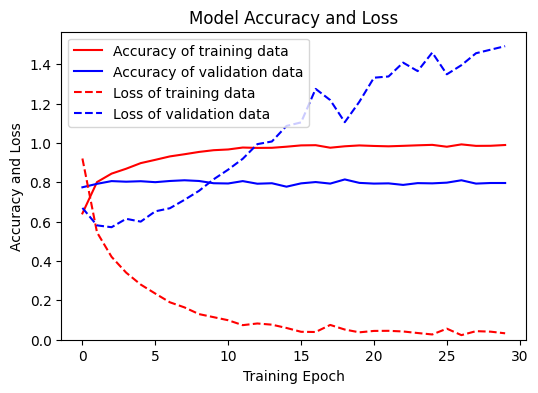

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

65/65 [==============================] - 0s 1ms/step


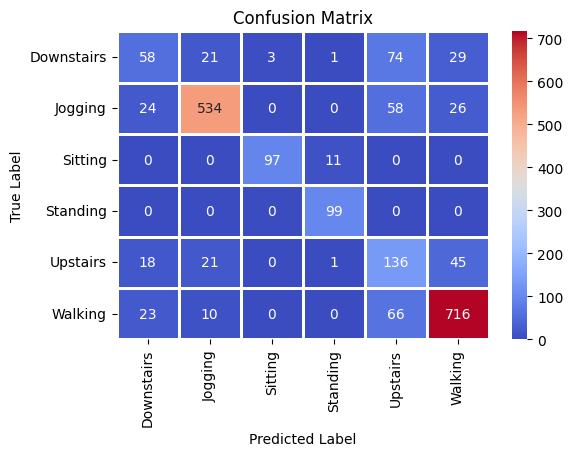

              precision    recall  f1-score   support

           0       0.47      0.31      0.38       186
           1       0.91      0.83      0.87       642
           2       0.97      0.90      0.93       108
           3       0.88      1.00      0.94        99
           4       0.41      0.62      0.49       221
           5       0.88      0.88      0.88       815

    accuracy                           0.79      2071
   macro avg       0.75      0.76      0.75      2071
weighted avg       0.81      0.79      0.79      2071



In [ ]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

## CNN을 사용하여 성능을 개선

In [ ]:
model_m = Sequential()
model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(N,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 91, 100)           1100      
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 100)           100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 100)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 160)           160160    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                               

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
332/332 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.6987

332/332 [==============================] - 10s 7ms/step - loss: 0.7759 - accuracy: 0.6987 - val_loss: 0.4562 - val_accuracy: 0.8238
Epoch 2/30
321/332 [============================>.] - ETA: 0s - loss: 0.4395 - accuracy: 0.8377

332/332 [==============================] - 2s 5ms/step - loss: 0.4402 - accuracy: 0.8378 - val_loss: 0.3941 - val_accuracy: 0.8503
Epoch 3/30
331/332 [============================>.] - ETA: 0s - loss: 0.3548 - accuracy: 0.8722

332/332 [==============================] - 2s 7ms/step - loss: 0.3549 - accuracy: 0.8722 - val_loss: 0.3410 - val_accuracy: 0.8696
Epoch 4/30
320/332 [===========================>..] - ETA: 0s - loss: 0.3051 - accuracy: 0.8853

332/332 [==============================] - 2s 5ms/step - loss: 0.3038 - accuracy: 0.8861 - val_loss: 0.2900 - val_accuracy: 0.8944
Epoch 5/30
325/332 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8982

332/332 [==============================] - 2s 5ms/step - loss: 0.2728 - accuracy: 0.8986 - val_loss: 0.2600 - val_accuracy: 0.9059
Epoch 6/30
327/332 [============================>.] - ETA: 0s - loss: 0.2394 - accuracy: 0.9107

332/332 [==============================] - 2s 5ms/step - loss: 0.2404 - accuracy: 0.9101 - val_loss: 0.2477 - val_accuracy: 0.9071
Epoch 7/30
330/332 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9185

332/332 [==============================] - 2s 5ms/step - loss: 0.2065 - accuracy: 0.9185 - val_loss: 0.2406 - val_accuracy: 0.9155
Epoch 8/30
324/332 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9306

332/332 [==============================] - 2s 5ms/step - loss: 0.1907 - accuracy: 0.9306 - val_loss: 0.2286 - val_accuracy: 0.9179
Epoch 9/30
328/332 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9351

332/332 [==============================] - 2s 6ms/step - loss: 0.1760 - accuracy: 0.9351 - val_loss: 0.2169 - val_accuracy: 0.9221
Epoch 10/30
326/332 [============================>.] - ETA: 0s - loss: 0.1514 - accuracy: 0.9442

332/332 [==============================] - 2s 6ms/step - loss: 0.1519 - accuracy: 0.9443 - val_loss: 0.2313 - val_accuracy: 0.9167
Epoch 11/30
332/332 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9510

332/332 [==============================] - 2s 5ms/step - loss: 0.1409 - accuracy: 0.9510 - val_loss: 0.2127 - val_accuracy: 0.9221
Epoch 12/30
324/332 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9515

332/332 [==============================] - 2s 5ms/step - loss: 0.1316 - accuracy: 0.9516 - val_loss: 0.2062 - val_accuracy: 0.9258
Epoch 13/30
323/332 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9577

332/332 [==============================] - 2s 5ms/step - loss: 0.1141 - accuracy: 0.9582 - val_loss: 0.2399 - val_accuracy: 0.9155
Epoch 14/30
322/332 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9629

332/332 [==============================] - 2s 5ms/step - loss: 0.1077 - accuracy: 0.9629 - val_loss: 0.2005 - val_accuracy: 0.9330
Epoch 15/30
331/332 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9645

332/332 [==============================] - 2s 5ms/step - loss: 0.1010 - accuracy: 0.9645 - val_loss: 0.2062 - val_accuracy: 0.9378
Epoch 16/30
327/332 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9682

332/332 [==============================] - 2s 7ms/step - loss: 0.0868 - accuracy: 0.9685 - val_loss: 0.2093 - val_accuracy: 0.9264
Epoch 17/30
321/332 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9749

332/332 [==============================] - 2s 6ms/step - loss: 0.0756 - accuracy: 0.9739 - val_loss: 0.2304 - val_accuracy: 0.9318
Epoch 18/30
330/332 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9726

332/332 [==============================] - 2s 5ms/step - loss: 0.0739 - accuracy: 0.9727 - val_loss: 0.2305 - val_accuracy: 0.9276
Epoch 19/30
323/332 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9772

332/332 [==============================] - 2s 5ms/step - loss: 0.0695 - accuracy: 0.9772 - val_loss: 0.2315 - val_accuracy: 0.9312
Epoch 20/30
328/332 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9787

332/332 [==============================] - 2s 5ms/step - loss: 0.0647 - accuracy: 0.9789 - val_loss: 0.2085 - val_accuracy: 0.9354
Epoch 21/30
332/332 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9823

332/332 [==============================] - 2s 5ms/step - loss: 0.0491 - accuracy: 0.9823 - val_loss: 0.2913 - val_accuracy: 0.9306
Epoch 22/30
328/332 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9782

332/332 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.9781 - val_loss: 0.2037 - val_accuracy: 0.9433
Epoch 23/30
326/332 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9798

332/332 [==============================] - 2s 7ms/step - loss: 0.0566 - accuracy: 0.9798 - val_loss: 0.2508 - val_accuracy: 0.9390
Epoch 24/30
321/332 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9836

332/332 [==============================] - 2s 5ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 0.2387 - val_accuracy: 0.9390
Epoch 25/30
328/332 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9860

332/332 [==============================] - 2s 5ms/step - loss: 0.0411 - accuracy: 0.9861 - val_loss: 0.2390 - val_accuracy: 0.9445
Epoch 26/30
322/332 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9884

332/332 [==============================] - 2s 5ms/step - loss: 0.0351 - accuracy: 0.9879 - val_loss: 0.3531 - val_accuracy: 0.9306
Epoch 27/30
329/332 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9816

332/332 [==============================] - 2s 5ms/step - loss: 0.0548 - accuracy: 0.9817 - val_loss: 0.1931 - val_accuracy: 0.9433
Epoch 28/30
326/332 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9893

332/332 [==============================] - 2s 5ms/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.2299 - val_accuracy: 0.9403
Epoch 29/30
329/332 [============================>.] - ETA: 0s - loss: 0.0302 - accuracy: 0.9900

332/332 [==============================] - 2s 5ms/step - loss: 0.0303 - accuracy: 0.9899 - val_loss: 0.2590 - val_accuracy: 0.9396
Epoch 30/30
332/332 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9855

332/332 [==============================] - 2s 7ms/step - loss: 0.0394 - accuracy: 0.9855 - val_loss: 0.2636 - val_accuracy: 0.9445


In [ ]:
model_m.evaluate(X_test, y_test)

65/65 [==============================] - 1s 12ms/step - loss: 0.2533 - accuracy: 0.9454


[0.253268837928772, 0.9454370141029358]

65/65 [==============================] - 0s 3ms/step


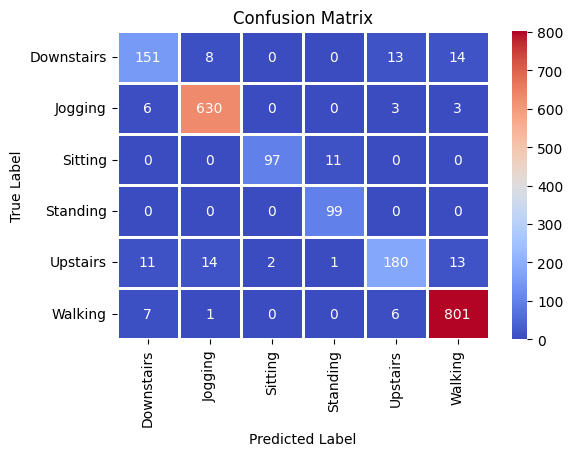

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       186
           1       0.96      0.98      0.97       642
           2       0.98      0.90      0.94       108
           3       0.89      1.00      0.94        99
           4       0.89      0.81      0.85       221
           5       0.96      0.98      0.97       815

    accuracy                           0.95      2071
   macro avg       0.93      0.91      0.92      2071
weighted avg       0.94      0.95      0.94      2071



In [ ]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
max_y_test.shape

(2071,)

# RNN으로 학습

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((N,1), input_shape=(N,)))
model.add(GRU(256, return_sequences=True, input_shape=(N,1)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 gru (GRU)                   (None, 100, 256)          198912    
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 595,206
Trainable params: 595,206
Non-tr

Epoch 1/30
329/332 [============================>.] - ETA: 0s - loss: 0.9750 - accuracy: 0.6243

332/332 [==============================] - 10s 15ms/step - loss: 0.9732 - accuracy: 0.6252 - val_loss: 0.6082 - val_accuracy: 0.7797
Epoch 2/30
329/332 [============================>.] - ETA: 0s - loss: 0.5675 - accuracy: 0.7933

332/332 [==============================] - 5s 14ms/step - loss: 0.5668 - accuracy: 0.7936 - val_loss: 0.5544 - val_accuracy: 0.7966
Epoch 3/30
329/332 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8429

332/332 [==============================] - 4s 12ms/step - loss: 0.4258 - accuracy: 0.8432 - val_loss: 0.3979 - val_accuracy: 0.8678
Epoch 4/30
329/332 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8653

332/332 [==============================] - 4s 13ms/step - loss: 0.3658 - accuracy: 0.8652 - val_loss: 0.3657 - val_accuracy: 0.8727
Epoch 5/30
328/332 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8890

332/332 [==============================] - 4s 13ms/step - loss: 0.3186 - accuracy: 0.8886 - val_loss: 0.4122 - val_accuracy: 0.8540
Epoch 6/30
332/332 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8957

332/332 [==============================] - 4s 12ms/step - loss: 0.2777 - accuracy: 0.8957 - val_loss: 0.2927 - val_accuracy: 0.8938
Epoch 7/30
329/332 [============================>.] - ETA: 0s - loss: 0.2327 - accuracy: 0.9144

332/332 [==============================] - 4s 13ms/step - loss: 0.2336 - accuracy: 0.9143 - val_loss: 0.2925 - val_accuracy: 0.8944
Epoch 8/30
332/332 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9244

332/332 [==============================] - 4s 13ms/step - loss: 0.2094 - accuracy: 0.9244 - val_loss: 0.2352 - val_accuracy: 0.9167
Epoch 9/30
328/332 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9428

332/332 [==============================] - 4s 13ms/step - loss: 0.1624 - accuracy: 0.9427 - val_loss: 0.2272 - val_accuracy: 0.9197
Epoch 10/30
329/332 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9407

332/332 [==============================] - 4s 13ms/step - loss: 0.1536 - accuracy: 0.9408 - val_loss: 0.2268 - val_accuracy: 0.9197
Epoch 11/30
328/332 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9512

332/332 [==============================] - 4s 13ms/step - loss: 0.1233 - accuracy: 0.9517 - val_loss: 0.2426 - val_accuracy: 0.9131
Epoch 12/30
329/332 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9622

332/332 [==============================] - 4s 12ms/step - loss: 0.1016 - accuracy: 0.9624 - val_loss: 0.2596 - val_accuracy: 0.9143
Epoch 13/30
328/332 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9700

332/332 [==============================] - 4s 13ms/step - loss: 0.0837 - accuracy: 0.9701 - val_loss: 0.2489 - val_accuracy: 0.9203
Epoch 14/30
329/332 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9638

332/332 [==============================] - 4s 12ms/step - loss: 0.0977 - accuracy: 0.9639 - val_loss: 0.2368 - val_accuracy: 0.9276
Epoch 15/30
330/332 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9745

332/332 [==============================] - 4s 13ms/step - loss: 0.0721 - accuracy: 0.9746 - val_loss: 0.2558 - val_accuracy: 0.9240
Epoch 16/30
329/332 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9790

332/332 [==============================] - 5s 14ms/step - loss: 0.0581 - accuracy: 0.9792 - val_loss: 0.2442 - val_accuracy: 0.9258
Epoch 17/30
329/332 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9872

332/332 [==============================] - 4s 12ms/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.2625 - val_accuracy: 0.9276
Epoch 18/30
330/332 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9826

332/332 [==============================] - 4s 12ms/step - loss: 0.0474 - accuracy: 0.9823 - val_loss: 0.3069 - val_accuracy: 0.9125
Epoch 19/30
330/332 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9770

332/332 [==============================] - 5s 14ms/step - loss: 0.0674 - accuracy: 0.9769 - val_loss: 0.2738 - val_accuracy: 0.9215
Epoch 20/30
330/332 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9750

332/332 [==============================] - 4s 13ms/step - loss: 0.0685 - accuracy: 0.9751 - val_loss: 0.2898 - val_accuracy: 0.9294
Epoch 21/30
330/332 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9847

332/332 [==============================] - 4s 13ms/step - loss: 0.0426 - accuracy: 0.9848 - val_loss: 0.2624 - val_accuracy: 0.9264
Epoch 22/30
330/332 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9867

332/332 [==============================] - 4s 13ms/step - loss: 0.0369 - accuracy: 0.9867 - val_loss: 0.3932 - val_accuracy: 0.9137
Epoch 23/30
329/332 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9874

332/332 [==============================] - 4s 12ms/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.2352 - val_accuracy: 0.9384
Epoch 24/30
328/332 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9852

332/332 [==============================] - 4s 12ms/step - loss: 0.0386 - accuracy: 0.9851 - val_loss: 0.2805 - val_accuracy: 0.9282
Epoch 25/30
332/332 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9817

332/332 [==============================] - 5s 14ms/step - loss: 0.0524 - accuracy: 0.9817 - val_loss: 0.2605 - val_accuracy: 0.9294
Epoch 26/30
328/332 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9881

332/332 [==============================] - 4s 12ms/step - loss: 0.0354 - accuracy: 0.9879 - val_loss: 0.2869 - val_accuracy: 0.9306
Epoch 27/30
330/332 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9888

332/332 [==============================] - 4s 12ms/step - loss: 0.0320 - accuracy: 0.9888 - val_loss: 0.3363 - val_accuracy: 0.9143
Epoch 28/30
332/332 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9878

332/332 [==============================] - 4s 13ms/step - loss: 0.0333 - accuracy: 0.9878 - val_loss: 0.3649 - val_accuracy: 0.9179
Epoch 29/30
330/332 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9850

332/332 [==============================] - 4s 12ms/step - loss: 0.0436 - accuracy: 0.9851 - val_loss: 0.3750 - val_accuracy: 0.9119
Epoch 30/30
329/332 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9824

65/65 [==============================] - 1s 8ms/step


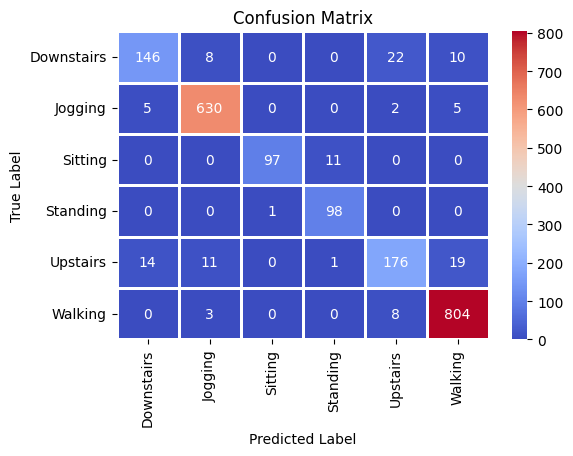

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       186
           1       0.97      0.98      0.97       642
           2       0.99      0.90      0.94       108
           3       0.89      0.99      0.94        99
           4       0.85      0.80      0.82       221
           5       0.96      0.99      0.97       815

    accuracy                           0.94      2071
   macro avg       0.92      0.91      0.91      2071
weighted avg       0.94      0.94      0.94      2071



In [ ]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 1s 10ms/step - loss: 0.2242 - accuracy: 0.9421


[0.22421444952487946, 0.9420569539070129]

# x,y,z 모두 사용할 때(Conv1D)

In [ ]:
X_3.shape

(10355, 100, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_hot, test_size = 0.2)

model_m = Sequential()
model_m.add(Conv1D(64, 10, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
332/332 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.7655

332/332 [==============================] - 4s 7ms/step - loss: 0.6302 - accuracy: 0.7655 - val_loss: 0.3377 - val_accuracy: 0.8847
Epoch 2/30
321/332 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8869

332/332 [==============================] - 2s 5ms/step - loss: 0.3142 - accuracy: 0.8882 - val_loss: 0.2157 - val_accuracy: 0.9294
Epoch 3/30
323/332 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9382

332/332 [==============================] - 2s 5ms/step - loss: 0.1933 - accuracy: 0.9390 - val_loss: 0.1549 - val_accuracy: 0.9541
Epoch 4/30
329/332 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9524

332/332 [==============================] - 2s 5ms/step - loss: 0.1462 - accuracy: 0.9525 - val_loss: 0.1269 - val_accuracy: 0.9565
Epoch 5/30
323/332 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9686

332/332 [==============================] - 2s 6ms/step - loss: 0.1055 - accuracy: 0.9679 - val_loss: 0.1297 - val_accuracy: 0.9559
Epoch 6/30
322/332 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9727

332/332 [==============================] - 2s 6ms/step - loss: 0.0898 - accuracy: 0.9725 - val_loss: 0.1144 - val_accuracy: 0.9632
Epoch 7/30
328/332 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9735

332/332 [==============================] - 2s 5ms/step - loss: 0.0821 - accuracy: 0.9733 - val_loss: 0.0872 - val_accuracy: 0.9722
Epoch 8/30
328/332 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9840

332/332 [==============================] - 2s 5ms/step - loss: 0.0527 - accuracy: 0.9842 - val_loss: 0.0902 - val_accuracy: 0.9698
Epoch 9/30
332/332 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9813

332/332 [==============================] - 2s 5ms/step - loss: 0.0595 - accuracy: 0.9813 - val_loss: 0.1104 - val_accuracy: 0.9632
Epoch 10/30
330/332 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9845

332/332 [==============================] - 2s 5ms/step - loss: 0.0499 - accuracy: 0.9842 - val_loss: 0.0889 - val_accuracy: 0.9728
Epoch 11/30
323/332 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9872

332/332 [==============================] - 2s 5ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.0549 - val_accuracy: 0.9801
Epoch 12/30
331/332 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9903

332/332 [==============================] - 2s 7ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0799 - val_accuracy: 0.9747
Epoch 13/30
325/332 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9894

332/332 [==============================] - 2s 5ms/step - loss: 0.0312 - accuracy: 0.9893 - val_loss: 0.0684 - val_accuracy: 0.9765
Epoch 14/30
330/332 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9879

332/332 [==============================] - 2s 5ms/step - loss: 0.0349 - accuracy: 0.9878 - val_loss: 0.0933 - val_accuracy: 0.9765
Epoch 15/30
327/332 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9869

332/332 [==============================] - 2s 5ms/step - loss: 0.0391 - accuracy: 0.9870 - val_loss: 0.0577 - val_accuracy: 0.9801
Epoch 16/30
323/332 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9923

332/332 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9925 - val_loss: 0.0555 - val_accuracy: 0.9843
Epoch 17/30
330/332 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9962

332/332 [==============================] - 2s 5ms/step - loss: 0.0155 - accuracy: 0.9962 - val_loss: 0.1087 - val_accuracy: 0.9753
Epoch 18/30
331/332 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9934

332/332 [==============================] - 2s 5ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.0516 - val_accuracy: 0.9825
Epoch 19/30
326/332 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9974

332/332 [==============================] - 2s 7ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0693 - val_accuracy: 0.9813
Epoch 20/30
330/332 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9953

332/332 [==============================] - 2s 6ms/step - loss: 0.0128 - accuracy: 0.9953 - val_loss: 0.0401 - val_accuracy: 0.9873
Epoch 21/30
323/332 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.9907

332/332 [==============================] - 2s 5ms/step - loss: 0.0320 - accuracy: 0.9905 - val_loss: 0.0695 - val_accuracy: 0.9777
Epoch 22/30
328/332 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9924

332/332 [==============================] - 2s 5ms/step - loss: 0.0224 - accuracy: 0.9925 - val_loss: 0.0565 - val_accuracy: 0.9837
Epoch 23/30
331/332 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9958

332/332 [==============================] - 2s 5ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 0.0677 - val_accuracy: 0.9789
Epoch 24/30
326/332 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9965

332/332 [==============================] - 2s 5ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 25/30
330/332 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9977

332/332 [==============================] - 2s 6ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.0850 - val_accuracy: 0.9765
Epoch 26/30
321/332 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9963

332/332 [==============================] - 2s 7ms/step - loss: 0.0157 - accuracy: 0.9961 - val_loss: 0.1083 - val_accuracy: 0.9747
Epoch 27/30
321/332 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9903

332/332 [==============================] - 2s 6ms/step - loss: 0.0425 - accuracy: 0.9906 - val_loss: 0.0467 - val_accuracy: 0.9867
Epoch 28/30
326/332 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9959

332/332 [==============================] - 2s 5ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0517 - val_accuracy: 0.9867
Epoch 29/30
323/332 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980

332/332 [==============================] - 2s 5ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.2363 - val_accuracy: 0.9541
Epoch 30/30
325/332 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9948

332/332 [==============================] - 2s 5ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 0.0682 - val_accuracy: 0.9819


65/65 [==============================] - 0s 3ms/step


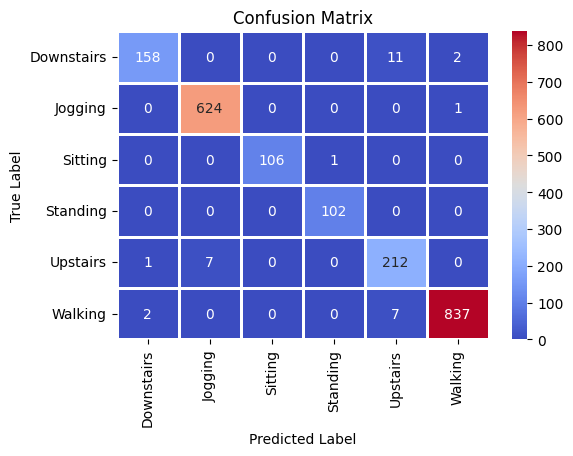

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       171
           1       0.99      1.00      0.99       625
           2       1.00      0.99      1.00       107
           3       0.99      1.00      1.00       102
           4       0.92      0.96      0.94       220
           5       1.00      0.99      0.99       846

    accuracy                           0.98      2071
   macro avg       0.98      0.98      0.98      2071
weighted avg       0.98      0.98      0.98      2071



In [ ]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z, RNN

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

Epoch 1/30
332/332 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.7270

332/332 [==============================] - 10s 15ms/step - loss: 0.7881 - accuracy: 0.7270 - val_loss: 0.4640 - val_accuracy: 0.8401
Epoch 2/30
331/332 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.8769

332/332 [==============================] - 4s 13ms/step - loss: 0.3453 - accuracy: 0.8767 - val_loss: 0.2414 - val_accuracy: 0.9179
Epoch 3/30
332/332 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9274

332/332 [==============================] - 5s 14ms/step - loss: 0.2140 - accuracy: 0.9274 - val_loss: 0.2044 - val_accuracy: 0.9366
Epoch 4/30
328/332 [============================>.] - ETA: 0s - loss: 0.1476 - accuracy: 0.9540

332/332 [==============================] - 4s 12ms/step - loss: 0.1473 - accuracy: 0.9540 - val_loss: 0.1518 - val_accuracy: 0.9517
Epoch 5/30
330/332 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9670

332/332 [==============================] - 4s 13ms/step - loss: 0.1017 - accuracy: 0.9670 - val_loss: 0.1794 - val_accuracy: 0.9421
Epoch 6/30
330/332 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9702

332/332 [==============================] - 5s 14ms/step - loss: 0.0907 - accuracy: 0.9703 - val_loss: 0.1037 - val_accuracy: 0.9614
Epoch 7/30
329/332 [============================>.] - ETA: 0s - loss: 0.0585 - accuracy: 0.9802

332/332 [==============================] - 4s 13ms/step - loss: 0.0581 - accuracy: 0.9804 - val_loss: 0.1198 - val_accuracy: 0.9620
Epoch 8/30
331/332 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9832

332/332 [==============================] - 4s 13ms/step - loss: 0.0512 - accuracy: 0.9833 - val_loss: 0.0962 - val_accuracy: 0.9728
Epoch 9/30
330/332 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9845

332/332 [==============================] - 5s 14ms/step - loss: 0.0451 - accuracy: 0.9846 - val_loss: 0.0745 - val_accuracy: 0.9759
Epoch 10/30
332/332 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9878

332/332 [==============================] - 4s 13ms/step - loss: 0.0349 - accuracy: 0.9878 - val_loss: 0.0933 - val_accuracy: 0.9728
Epoch 11/30
332/332 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9842

332/332 [==============================] - 5s 14ms/step - loss: 0.0491 - accuracy: 0.9842 - val_loss: 0.1044 - val_accuracy: 0.9674
Epoch 12/30
328/332 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9915

332/332 [==============================] - 5s 15ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.0697 - val_accuracy: 0.9771
Epoch 13/30
330/332 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9873

332/332 [==============================] - 4s 12ms/step - loss: 0.0370 - accuracy: 0.9873 - val_loss: 0.0958 - val_accuracy: 0.9680
Epoch 14/30
330/332 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9882

332/332 [==============================] - 4s 12ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.0898 - val_accuracy: 0.9710
Epoch 15/30
332/332 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9931

332/332 [==============================] - 4s 13ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0706 - val_accuracy: 0.9740
Epoch 16/30
328/332 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9974

332/332 [==============================] - 4s 13ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.0842 - val_accuracy: 0.9753
Epoch 17/30
332/332 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9920

332/332 [==============================] - 4s 13ms/step - loss: 0.0301 - accuracy: 0.9920 - val_loss: 0.0885 - val_accuracy: 0.9680
Epoch 18/30
329/332 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9941

332/332 [==============================] - 4s 13ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0611 - val_accuracy: 0.9801
Epoch 19/30
331/332 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9946

332/332 [==============================] - 4s 13ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0630 - val_accuracy: 0.9819
Epoch 20/30
331/332 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9935

332/332 [==============================] - 5s 14ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0636 - val_accuracy: 0.9819
Epoch 21/30
332/332 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9970

332/332 [==============================] - 4s 12ms/step - loss: 0.0112 - accuracy: 0.9970 - val_loss: 0.0631 - val_accuracy: 0.9825
Epoch 22/30
330/332 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9933

332/332 [==============================] - 4s 12ms/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0842 - val_accuracy: 0.9807
Epoch 23/30
332/332 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9947

332/332 [==============================] - 5s 14ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0552 - val_accuracy: 0.9843
Epoch 24/30
332/332 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9958

332/332 [==============================] - 4s 12ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.0831 - val_accuracy: 0.9777
Epoch 25/30
329/332 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9918

332/332 [==============================] - 4s 12ms/step - loss: 0.0214 - accuracy: 0.9919 - val_loss: 0.0646 - val_accuracy: 0.9837
Epoch 26/30
332/332 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9983

332/332 [==============================] - 5s 14ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0710 - val_accuracy: 0.9807
Epoch 27/30
329/332 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9962

332/332 [==============================] - 4s 13ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0678 - val_accuracy: 0.9849
Epoch 28/30
331/332 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9976

332/332 [==============================] - 4s 12ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0929 - val_accuracy: 0.9843
Epoch 29/30
328/332 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9974

332/332 [==============================] - 4s 14ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0757 - val_accuracy: 0.9819
Epoch 30/30
328/332 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9963

65/65 [==============================] - 1s 5ms/step


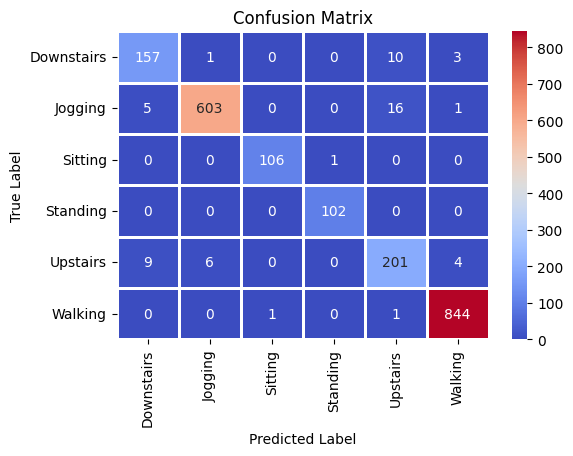

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       171
           1       0.99      0.96      0.98       625
           2       0.99      0.99      0.99       107
           3       0.99      1.00      1.00       102
           4       0.88      0.91      0.90       220
           5       0.99      1.00      0.99       846

    accuracy                           0.97      2071
   macro avg       0.96      0.96      0.96      2071
weighted avg       0.97      0.97      0.97      2071



In [ ]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# Exercise

In [ ]:
# Regular string with escape characters
normal_string = "Hello\nWorld"
print(normal_string)

# Raw string with escape characters treated as literals
raw_string = r"Hello\nWorld"
print(raw_string)

Hello
World
Hello\nWorld
